# LIBRARIES

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
import os, shutil
import csv
import math

# PRE-PROCESSING

In [4]:
# CONFIGURATION
# Number of images and numpys array
Nimg = 14
Naug = 8
width = 512
height = 512

# Data augmentation
imageData = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="constant",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last")

maskData = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="constant",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last")

# Output folders
directories = ('images', 'masks', 'articulo')
for names in directories:
    if os.path.isdir("./"+names):
        shutil.rmtree("./"+names)
        os.mkdir("./"+names)
    else:
        os.mkdir("./"+names)

# ORIGINAL IMAGES
# Convert image to numpy
for i in range(Nimg):
    # Image
    image = np.genfromtxt('../input/data-images/csv/train/images/'+str(i+1)+'z.csv', delimiter=',')
    # Mask
    mask = np.genfromtxt(('../input/data-images/csv/train/masks/'+str(i+1)+'z.csv'), delimiter=',')
    
    image = np.expand_dims(image, axis = (0,3))
    mask = np.expand_dims(mask, axis = (0,3))
    #print("Images array shape:", image.shape)
    #print("Masks array shape:", mask.shape)
    
    imageGen = imageData.flow(image, seed=0, batch_size=1, save_to_dir="./images/", save_prefix=str(i)+"", save_format="png", subset='training')
    maskGen = maskData.flow(mask, seed=0, batch_size=1, save_to_dir="./masks/", save_prefix=str(i)+"", save_format="png", subset='training')
    
    for l in range(Naug):
        for elements in imageGen: break
        for elements in maskGen: break

In [5]:
images = np.empty((Naug*Nimg, height, width))
masks = np.empty((Naug*Nimg, height, width))

for _, _, names in os.walk("./images"): pass
for i in range(Naug*Nimg-1):
    image = Image.open("./images/"+names[i])
    image = ImageOps.pad(image, (width, height), method=Image.LANCZOS, color="black", centering=(0.5, 0.5))
    images[i] = np.asarray(image)
for i in range(Naug*Nimg-1):
    mask = Image.open("./masks/"+names[i])
    mask = ImageOps.pad(mask, (width, height), method=Image.LANCZOS, color="black", centering=(0.5, 0.5))
    masks[i] = np.asarray(mask)

# Numpy adjust
images = (images - np.min(images))/(np.max(images) - np.min(images))
masks = (masks - np.min(masks))/(np.max(masks) - np.min(masks))
masks = np.where(masks>0.5, 1.0, 0.0)
print('Max image pixel value: ', np.max(images), '\tMax mask pixel value: ', np.max(masks))
print('Min image pixel value: ', np.min(images), '\tMin mask pixel value: ', np.min(masks))

# Add second channel
x_train = np.empty((images.shape[0], images.shape[1], images.shape[2], 2))
y_train = np.empty((masks.shape[0], masks.shape[1], masks.shape[2], 2))
for i in range(x_train.shape[0]):
    x_train[i,:,:,0] = x_train[i,:,:,1] = images[i,:,:]
    for j in range(x_train.shape[1]):
        for k in range(x_train.shape[2]):
            if masks[i,j,k] == 0:
                y_train[i,j,k,0] = 0
                y_train[i,j,k,1] = 1
            else:
                y_train[i,j,k,0] = 1
                y_train[i,j,k,1] = 0

print("image array shape:", x_train.shape, "\nMask array shape:", y_train.shape)

Max image pixel value:  1.0 	Max mask pixel value:  1.0
Min image pixel value:  0.0 	Min mask pixel value:  0.0
image array shape: (112, 512, 512, 2) 
Mask array shape: (112, 512, 512, 2)


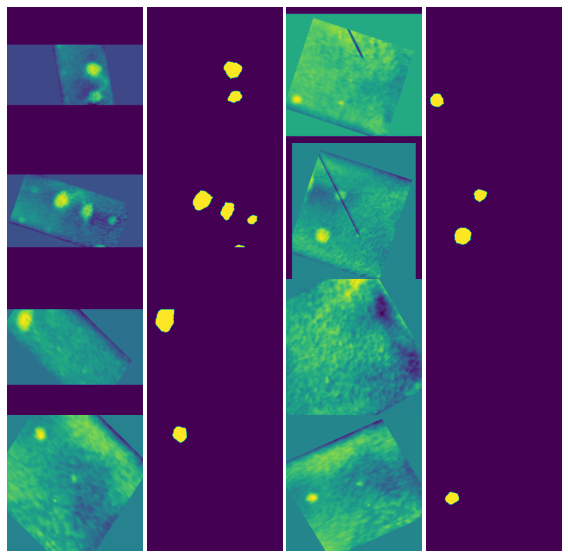

In [6]:
# Entry data visualization
c = 4
r = int(len(x_train/(c)))
if r>4: r=4
fig, ax = plt.subplots(r, c, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)

n = 0
for row in range(r):
    for col in range(c):
        if col%2==0:
            ax[row][col].imshow(x_train[n,:,:,0])
            ax[row][col].axis('off')
        else:
            n-=1
            ax[row][col].imshow(y_train[n,:,:,0])
            ax[row][col].axis('off')
        n+=1

# NETWORK ARCHITECTURE

In [8]:
# Unet definition
Nfilters = 64
def unet(input_shape):
    input = Input(input_shape)
    # Encoder
    # Block1
    x0 = Conv2D(Nfilters, (3, 3), padding="same", data_format="channels_last")(input)
    x0 = BatchNormalization()(x0)
    x0 = Activation("relu")(x0)
    x0 = Conv2D(Nfilters, (3, 3), padding="same", data_format="channels_last")(x0)
    x0 = BatchNormalization()(x0)
    x0 = Activation("relu")(x0)
    p1 = MaxPool2D((2, 2))(x0)
    # Block2
    x1 = Conv2D(Nfilters*2, (3, 3), padding="same", data_format="channels_last")(p1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Conv2D(Nfilters*2, (3, 3), padding="same", data_format="channels_last")(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    p2 = MaxPool2D((2, 2))(x1)
    # Block3
    x2 = Conv2D(Nfilters*4, (3,3), padding="same", data_format="channels_last")(p2)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = Conv2D(Nfilters*4, (3, 3), padding="same", data_format="channels_last")(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    p3 = MaxPool2D((2, 2))(x2)
    # Block4
    x3 = Conv2D(Nfilters*8, (3,3), padding="same", data_format="channels_last")(p3)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    x3 = Conv2D(Nfilters*8, (3, 3), padding="same", data_format="channels_last")(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    p4 = MaxPool2D((2, 2))(x3)

    # Bridge
    # Block5
    x4 = Conv2D(Nfilters*16, (3,3), padding="same", data_format="channels_last")(p4)
    x4 = BatchNormalization()(x4)
    x4 = Activation("relu")(x4)
    x4 = Conv2D(Nfilters*16, (3, 3), padding="same", data_format="channels_last")(x4)
    x4 = BatchNormalization()(x4)
    x4 = Activation("relu")(x4)

    # Decoder
    # Block6
    x5 = Conv2DTranspose(Nfilters*8, (2,2), strides=2, padding="same", data_format="channels_last")(x4)
    x5 = BatchNormalization()(x5)
    x5 = Activation("relu")(x5)
    x5 = Concatenate(axis=3)([x5, x3])
    x5 = Conv2D(Nfilters*8, (3,3), padding="same", data_format="channels_last")(x5)
    x5 = BatchNormalization()(x5)
    x5 = Activation("relu")(x5)
    x5 = Conv2D(Nfilters*8, (3, 3), padding="same", data_format="channels_last")(x5)
    x5 = BatchNormalization()(x5)
    x5 = Activation("relu")(x5)
    # Block7
    x6 = Conv2DTranspose(Nfilters*4, (2,2), strides=2, padding="same", data_format="channels_last")(x5)
    x6 = BatchNormalization()(x6)
    x6 = Activation("relu")(x6)
    x6 = Concatenate(axis=3)([x6, x2])
    x6 = Conv2D(Nfilters*4, (3,3), padding="same", data_format="channels_last")(x6)
    x6 = BatchNormalization()(x6)
    x6 = Activation("relu")(x6)
    x6 = Conv2D(Nfilters*4, (3, 3), padding="same", data_format="channels_last")(x6)
    x6 = BatchNormalization()(x6)
    x6 = Activation("relu")(x6)
    # Block8
    x7 = Conv2DTranspose(Nfilters*2, (2,2), strides=2, padding="same", data_format="channels_last")(x6)
    x7 = BatchNormalization()(x7)
    x7 = Activation("relu")(x7)
    x7 = Concatenate(axis=3)([x7, x1])
    x7 = Conv2D(Nfilters*2, (3,3), padding="same", data_format="channels_last")(x7)
    x7 = BatchNormalization()(x7)
    x7 = Activation("relu")(x7)
    x7 = Conv2D(Nfilters*2, (3, 3), padding="same", data_format="channels_last")(x7)
    x7 = BatchNormalization()(x7)
    x7 = Activation("relu")(x7)
    # Block9
    x8 = Conv2DTranspose(Nfilters, (2,2), strides=2, padding="same", data_format="channels_last")(x7)
    x8 = BatchNormalization()(x8)
    x8 = Activation("relu")(x8)
    x8 = Concatenate(axis=3)([x8, x0])
    x8 = Conv2D(Nfilters, (3,3), padding="same", data_format="channels_last")(x8)
    x8 = BatchNormalization()(x8)
    x8 = Activation("relu")(x8)
    x8 = Conv2D(Nfilters, (3, 3), padding="same", data_format="channels_last")(x8)
    x8 = BatchNormalization()(x8)
    x8 = Activation("relu")(x8)

    # Output
    output = Conv2D(2, (1, 1), padding="same", activation="sigmoid", data_format="channels_last")(x8)

    model = Model(input, output, name="U-Net")
    model.compile(optimizer=Adam(learning_rate=0.0003), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

# TRAINING

In [9]:
model = unet((None, None, 2))

callback = [ModelCheckpoint('./unet.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_loss'),
            EarlyStopping(monitor="val_loss", patience=15, verbose=2, mode="auto", restore_best_weights=True)]
history = model.fit(x_train, y_train, batch_size=8, epochs=150, verbose=1, callbacks=callback, validation_split=0.1, validation_batch_size=8)

Epoch 1/150
13/13 [==============================] - 78s 4s/step - loss: 0.4521 - accuracy: 0.9199 - val_loss: 0.6866 - val_accuracy: 0.5865

Epoch 00001: val_loss improved from inf to 0.68660, saving model to ./unet.h5
Epoch 2/150
13/13 [==============================] - 29s 2s/step - loss: 0.2175 - accuracy: 0.9879 - val_loss: 3.0742 - val_accuracy: 0.2794

Epoch 00002: val_loss did not improve from 0.68660
Epoch 3/150
13/13 [==============================] - 28s 2s/step - loss: 0.1722 - accuracy: 0.9923 - val_loss: 0.5773 - val_accuracy: 0.8200

Epoch 00003: val_loss improved from 0.68660 to 0.57729, saving model to ./unet.h5
Epoch 4/150
13/13 [==============================] - 28s 2s/step - loss: 0.1455 - accuracy: 0.9934 - val_loss: 0.4582 - val_accuracy: 0.9894

Epoch 00004: val_loss improved from 0.57729 to 0.45820, saving model to ./unet.h5
Epoch 5/150
13/13 [==============================] - 28s 2s/step - loss: 0.1356 - accuracy: 0.9919 - val_loss: 0.3928 - val_accuracy: 0.989

<Figure size 432x288 with 0 Axes>

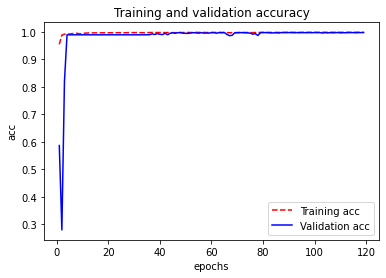

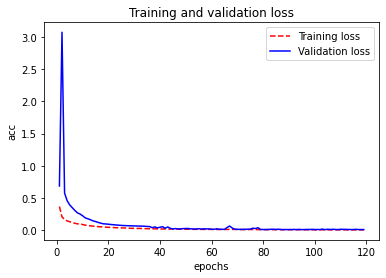

<Figure size 432x288 with 0 Axes>

In [10]:
#Training and test accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1,1)

plt.plot ( epochs, acc, 'r--', label='Training acc')
plt.plot ( epochs, val_acc, 'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs, loss, 'r--', label='Training loss')
plt.plot ( epochs, val_loss , 'b', label='Validation loss')
plt.title ('Training and validation loss')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

# PRE-TRAINED MODEL

In [ ]:
# Data augmentation
imageData = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode="constant",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last")

imageGen = imageData.flow(images, batch_size=2, save_to_dir="./images/", save_prefix="", save_format="png", subset='training')

for i in range(Naug*2):
    for elements in imageGen: break

images = np.empty((Naug*Nimg, height, width))

for _, _, names in os.walk("./images"): pass
for i in range(Naug*Nimg-1):
    image = Image.open("./images/"+names[i])
    images[i] = np.asarray(image)

# Numpy adjust
images = (images - np.min(images))/(np.max(images) - np.min(images))

print('Max image pixel value: ', np.max(images))
print('Min image pixel value: ', np.min(images))

# Add second channel
x_test = np.empty((images.shape[0], images.shape[1], images.shape[2], 2))
for i in range(x_test.shape[0]):
    x_test[i,:,:,0] = x_test[i,:,:,1] = images[i,:,:]

print("image array shape:", x_test.shape)

In [12]:
Nimg = 4

model = unet((None, None, 2))
model.load_weights('../input/pretrained-weight/unet.h5')

for i in range(Nimg):
    image = np.genfromtxt("../input/data-images/csv/test/"+str(i+1)+"z.csv", delimiter=",")
    xp = np.genfromtxt("../input/data-images/csv/test/"+str(i+1)+"x.csv", delimiter=",")
    yp = np.genfromtxt("../input/data-images/csv/test/"+str(i+1)+"y.csv", delimiter=",")
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    #print("Max: ", np.max(image), "min: ", np.min(image))
    sizex = image.shape[0]
    sizey = image.shape[1]
    
    if sizex>sizey:
        proportion = sizex/sizey
        width = 512
        height = int(512/proportion)
    if sizey>sizex:
        proportion = sizey/sizex
        width = int(512/proportion)
        height = 512
        
    image = cv2.resize(image, (height, width), interpolation= cv2.INTER_LANCZOS4)
    
    shape0 = 0
    shape1 = 0
    while image.shape[0]<512:
        image = np.insert(image, 1, 0, axis = 0)
        shape0 += 1
    while image.shape[1]<512:
        image = np.insert(image, 1, 0, axis = 1)
        shape1 += 1
    
    image = np.expand_dims(image, axis=(0,3))
    
    entry = np.zeros((1, image.shape[1], image.shape[2], 2))
    entry[:,:,:,0] = entry[:,:,:,1] = image[:,:,:,0]
    image = np.reshape(image, (image.shape[1], image.shape[2]))
    
    out = model.predict(entry)
    output = out[0,:,:,0]
    
    output = np.where(output<0.55, 0, 1)
    output = output.astype(np.uint8)
    
    # Morphology closing
    kernel = np.ones((25,25),np.uint8)
    output = cv2.morphologyEx(output, cv2.MORPH_CLOSE, kernel)
    
    while image.shape[0]>width:
        image = np.delete(image, 0, axis = 0)
        output = np.delete(output, 0, axis = 0)
    while image.shape[1]>height:
        image = np.delete(image, 0, axis = 1)
        output = np.delete(output, 0, axis = 1)
    image = cv2.resize(image, (sizey, sizex), interpolation= cv2.INTER_LANCZOS4)
    output = cv2.resize(output, (sizey, sizex), interpolation= cv2.INTER_LANCZOS4)
    
    # Contour detection
    contour,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(image, contour, -1, (0,255,0), 3)
    
    #print("Shape: ", "\nX: ", xp.shape, "\nY: ", yp.shape, "\nZ: ", image.shape)
    
    for value in contour:
        if value.shape[0]>5:
            minEllipse = cv2.fitEllipse(value)        

            #Extreme points and diameter
            angle = minEllipse[2]
            if angle > 90:
                angle -= 90
            else:
                angle += 90

            p1x = int(minEllipse[0][0] + math.cos(math.radians(angle+180))*(minEllipse[1][1]/2))
            p1y = int(minEllipse[0][1] + math.sin(math.radians(angle+180))*(minEllipse[1][1]/2))
            p2x = int(minEllipse[0][0] + math.cos(math.radians(angle))*(minEllipse[1][1]/2))
            p2y = int(minEllipse[0][1] + math.sin(math.radians(angle))*(minEllipse[1][1]/2))
            theta = math.radians(minEllipse[2])
        
            #print("Points: ", "\n1: ", p1x, "\n2: ", p1y, "\n3: ", p2x, "\n4: ", p2y)

            x1 = xp[p1y, p1x]
            x2 = xp[p2y, p2x]
            y1 = yp[p1y, p1x]
            y2 = yp[p2y, p2x]

            diameter = math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2))
        
            if diameter > 3:
                cv2.ellipse(image, minEllipse, (0,255,0), 3)
                cv2.putText(image, str(round(diameter, 2)), (int(minEllipse[0][0]-(minEllipse[1][0]/4)), int(minEllipse[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    image = Image.fromarray(image*255).convert("L")
    image.save("./"+str(i)+".jpg")

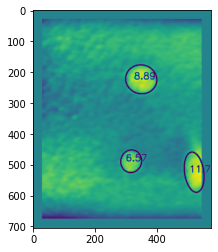

In [13]:
plt.imshow(image)